The performer that compete more than 3 times is: Fud Leclerc

The composers that composed more than 3 songs are: Andrej Babić  -André Popp  -Arne Bendiksen  -Brendan J. Graham  -Dimitris Kontopoulos  -Dimitris Kontopoulos;Philipp Kirkorov  -Domenico Modugno  -Géo Voumard  -Hubert Giraud  -Juan Carlos Calderón  -Lasse Holm  -Marc Paelinck  -Matjaž Vlašič  -Nikos Terzis  -Paul Quintens  -Peter Reber  -Philip Vella  -Ralph Siegel  -Rolf Løvland  -Sven Lõhmus  -Søren Bundgaard  -Tonči Huljić  -Udo Jürgens  -Željko Joksimović

Israel placing: 
place_final
1.0     4
7.0     3
23.0    3
11.0    2
6.0     2
2.0     2
5.0     2
19.0    2
8.0     2
12.0    2
3.0     2
16.0    2
9.0     2
14.0    2
4.0     2
18.0    1
24.0    1
22.0    1
17.0    1
Name: count, dtype: int64



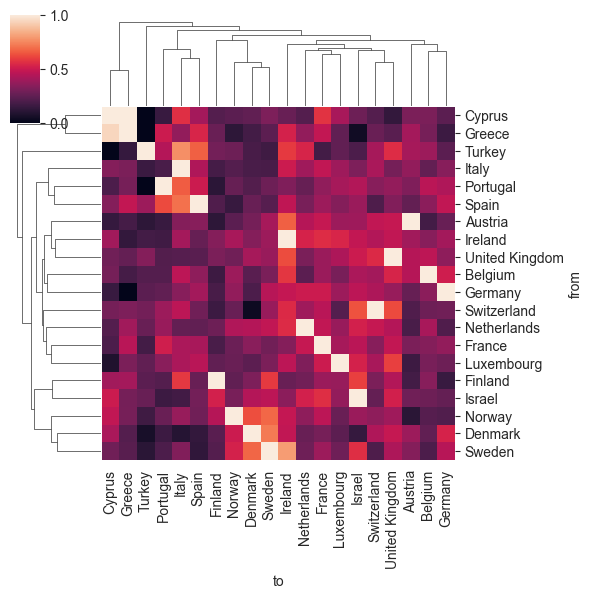

C:\Users\malia\AppData\Local\Temp\ipykernel_11116\576638773.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=israel.values, y=israel.index, palette='coolwarm')


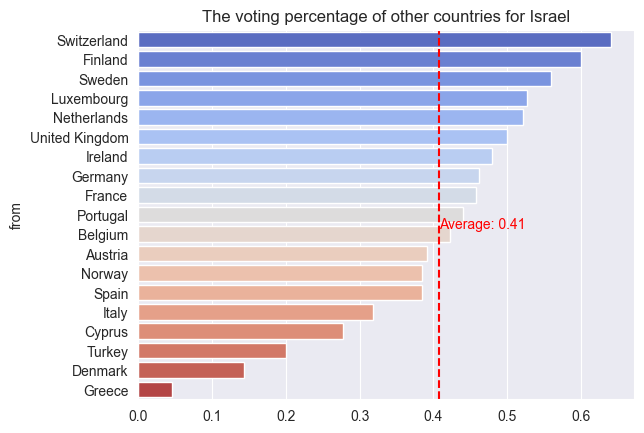

C:\Users\malia\AppData\Local\Temp\ipykernel_11116\576638773.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=israel.values, y=israel.index, palette='coolwarm')


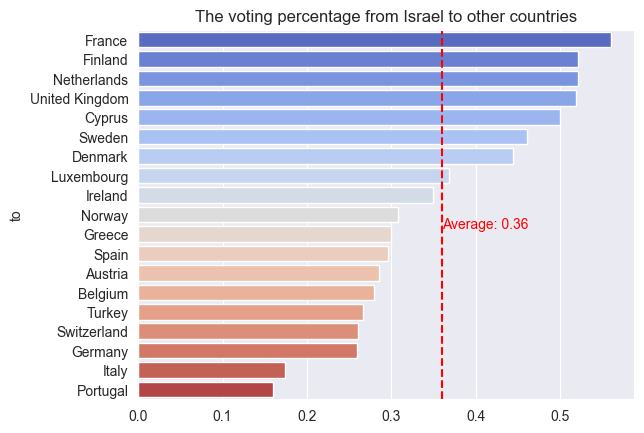

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

""" 1. Contest data """
# A
data_csv = pd.read_csv("C:contestants.csv", header=0)
data_csv.set_index('to_country_id', drop=False)
comp_num = data_csv.groupby('to_country_id')['year'].count()
place_median = data_csv.groupby('to_country_id')['place_final'].median()
num_first = data_csv[data_csv['place_final'] == 1].groupby('to_country_id')['place_final'].count()
prec = num_first / comp_num * 100
final_data = pd.concat([comp_num, place_median, num_first, prec], axis='columns',
                       keys=['compete_num', 'plac_final_med', 'first_place_num', 'first_place_for_compete'])
final_data.fillna(value=0, inplace=True)
final_data.sort_values(by='first_place_for_compete', inplace=True, ascending=False)

# b
artists = data_csv.groupby('performer').count()
print(f"The performer that compete more than 3 times is: {'  -'.join(artists[artists['year'] > 3].index.tolist())}",
      end='\n\n')

# c
composers = data_csv.groupby('composers').count()
print(
    f"The composers that composed more than 3 songs are: {'  -'.join(composers[composers['year'] > 3].index.tolist())}",
    end='\n\n')

# d
israel_placing = data_csv[data_csv['to_country'] == 'Israel']['place_final'].value_counts().sort_values(ascending=False)
print(f"Israel placing: \n{israel_placing}", end='\n\n')

""" 2. Creating dictionary to convert Country's name from short to long """
codeToCountry = data_csv[['to_country_id', 'to_country']]
codeToCountry = codeToCountry.drop_duplicates(keep='first', ignore_index=True)
codes = codeToCountry['to_country_id'].to_frame()
names = codeToCountry['to_country'].to_frame()

code_to_country = {}
for key, value in zip(codes.values, names.values):
    code_to_country[key[0]] = value[0]
code_to_country['ad'] = 'Audience'
code_to_country['wld'] = 'World'

""" 3. Analysis of the politicization of the Eurovision """
votes = pd.read_csv(
    "C:votes.csv",
    header=0)
votes.drop(votes[votes['round'] != 'final'].index, inplace=True)
votes['from_country_id'] = votes['from_country_id'].apply(lambda x: code_to_country[x])
votes['to_country_id'] = votes['to_country_id'].apply(lambda x: code_to_country[x])
comp_num.rename(code_to_country, inplace=True)
comp_over_30 = comp_num[comp_num >= 30]
drop_index_to = votes.loc[votes['to_country_id'].apply(lambda x: x not in comp_over_30)].index
votes.drop(index=drop_index_to, inplace=True)
drop_index_from = votes.loc[votes['from_country_id'].apply(lambda x: x not in comp_over_30)].index
votes.drop(index=drop_index_from, inplace=True)
votes = votes[~((votes['jury_points'].isna()) & (votes['year'] > 1996))]
votes.loc[votes['year'] > 1996, 'total_points'] = votes.loc[votes['year'] > 1996, 'jury_points']
votes.rename(columns={'from_country_id': 'from', 'to_country_id': 'to', 'total_points': 'points'}, inplace=True)
votes.drop(columns=[x for x in votes.columns if x not in ['year', 'from', 'to', 'points']], inplace=True)

# mean
mean_points = votes.groupby(['year', 'to'])['points'].mean().reset_index()
mean_points.rename(columns={'to': 'country', 'points': 'mean_points'}, inplace=True)
mean_points['year.country'] = mean_points['year'].astype(str) + '.' + mean_points['country']
mean_points.set_index('year.country', inplace=True)

# norm
votes = votes.merge(mean_points, left_on=['year', 'to'], right_on=['year', 'country'])
votes['adjusted_points'] = votes['points'] - votes['mean_points']
votes['above_average'] = votes['adjusted_points'] > 0
votes.loc[votes['from'] == votes['to'], 'above_average'] = True
from_to_above_average = votes.groupby(['from', 'to'])['above_average'].mean().unstack(fill_value=0)

""" 4. Create a matrix of scoring countries(rows) to scoring countries (columns) """
sns.clustermap(from_to_above_average, figsize=(6, 6))
plt.show()

israel = from_to_above_average['Israel'].drop('Israel').sort_values(ascending=False)
sns.barplot(x=israel.values, y=israel.index, palette='coolwarm')
mean_value = israel.mean()
plt.axvline(mean_value, color='r', linestyle='--')
plt.text(mean_value, len(israel) / 2, f'Average: {mean_value:.2f}', color='r', va='center')
plt.title("The voting percentage of other countries for Israel")
plt.show()


israel = from_to_above_average.loc['Israel'].drop('Israel').sort_values(ascending=False)
sns.barplot(x=israel.values, y=israel.index, palette='coolwarm')
mean_value = israel.mean()
plt.axvline(mean_value, color='r', linestyle='--')
plt.text(mean_value, len(israel) / 2, f'Average: {mean_value:.2f}', color='r', va='center')
plt.title("The voting percentage from Israel to other countries")
plt.show()
